In [1]:
import numpy as np

import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from functools import reduce 

# Global Annual Average Temperature

In [2]:
site = 'https://www.metoffice.gov.uk'
path = 'hadobs/hadcrut5/data/current/analysis/diagnostics'
file = 'HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'

url = site + '/' + path + '/' + file

In [3]:
hadcrut5 = pd.read_csv(url)

In [4]:
df = hadcrut5

mean = df[(1850 <= df['Time']) & (df['Time'] <= 1900)]['Anomaly (deg C)'].mean()

df = df.rename(columns={
                            'Time':                           'time',
                            'Anomaly (deg C)':                'anomaly',
                            'Lower confidence limit (2.5%)':  'lower',
                            'Upper confidence limit (97.5%)': 'upper'
})

df[['anomaly', 'lower', 'upper']] -= mean

current_year    = df.tail(1)['time'].values[0]
current_anomaly = df.tail(1)['anomaly'].values[0]

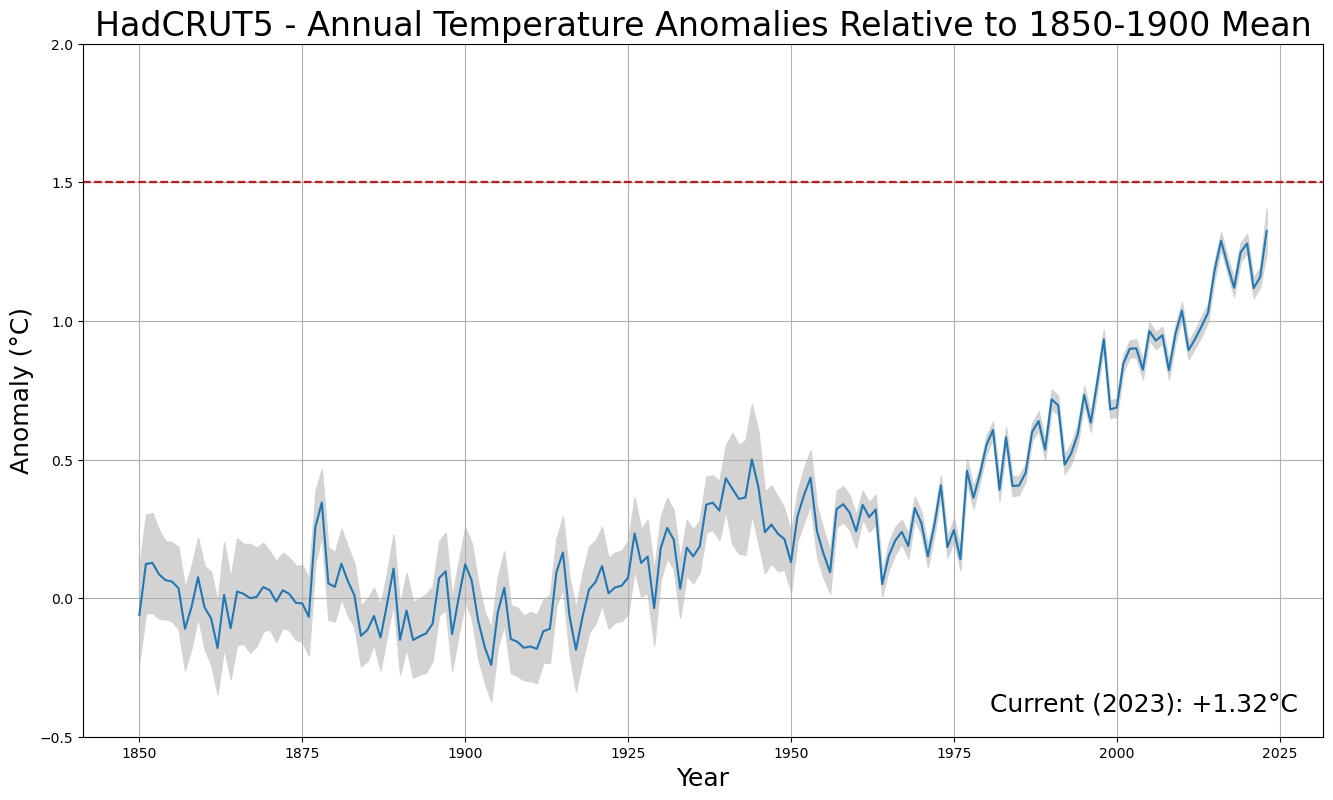

In [5]:
plt.rcParams["figure.figsize"] = (16,9)

ax = plt.gca()

plt.plot(df['time'].values, df['anomaly'].values)

ax.set_ylim([-0.5, 2.0])

plt.fill_between(df['time'].values, df['lower'].values, df['upper'].values, color="lightgray")

plt.axhline(y = 1.5, color = 'r', linestyle = 'dashed')

plt.xlabel('Year', size = 18)
plt.ylabel('Anomaly (°C)', size = 18)

plt.title('HadCRUT5 - Annual Temperature Anomalies Relative to 1850-1900 Mean', size = 24)

plt.annotate(
    "Current ({0}): {1:+.2f}°C".format(current_year, current_anomaly),
    xy=(0.98, 0.03),
    xycoords="axes fraction",
    fontsize=18,
    horizontalalignment="right",
    verticalalignment="bottom",
)

plt.grid()

plt.savefig('images/global_annual_average_temperature.png')

plt.show()

![Global Average Temperature (°C) Relative To1850-1900](https://www.metoffice.gov.uk/binaries/content/gallery/metofficegovuk/images/research/news/2020/hadcrut5_timeseries_comparison.png)

# Energy Consumption

## Annual Energy Consumption

### Global Annual Primary Energy Consumption by Region

In [6]:
raw_owid_energy_data = pd.read_csv(
    'https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv'
)

In [7]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                            'World'
                        ]]

df = reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

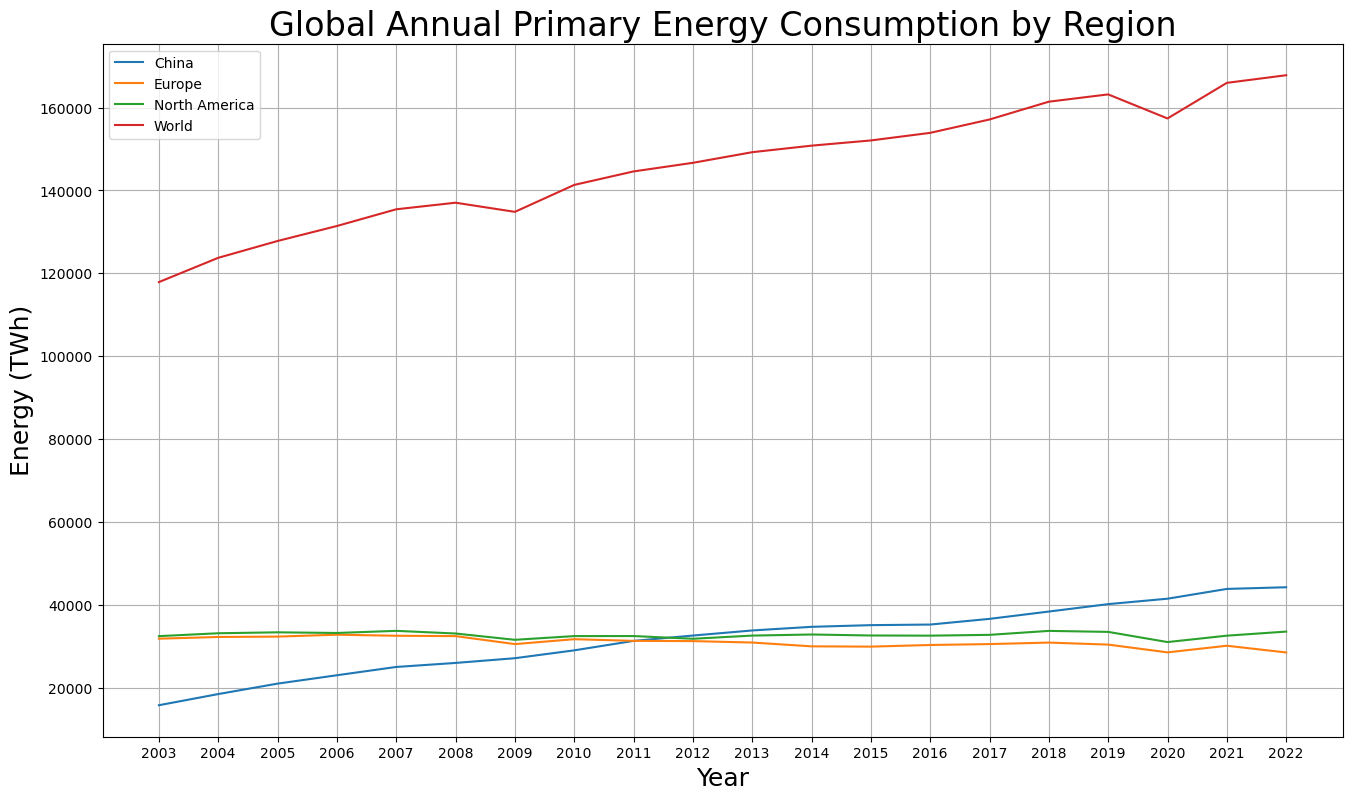

In [8]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Primary Energy Consumption by Region', size = 24)

plt.grid()

plt.savefig('images/global_annual_primary_energy_consumption_by_region.png')

plt.show()

### Global Annual Primary Energy Consumption by Source

In [9]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
    'primary_energy_consumption': 'Total',
})

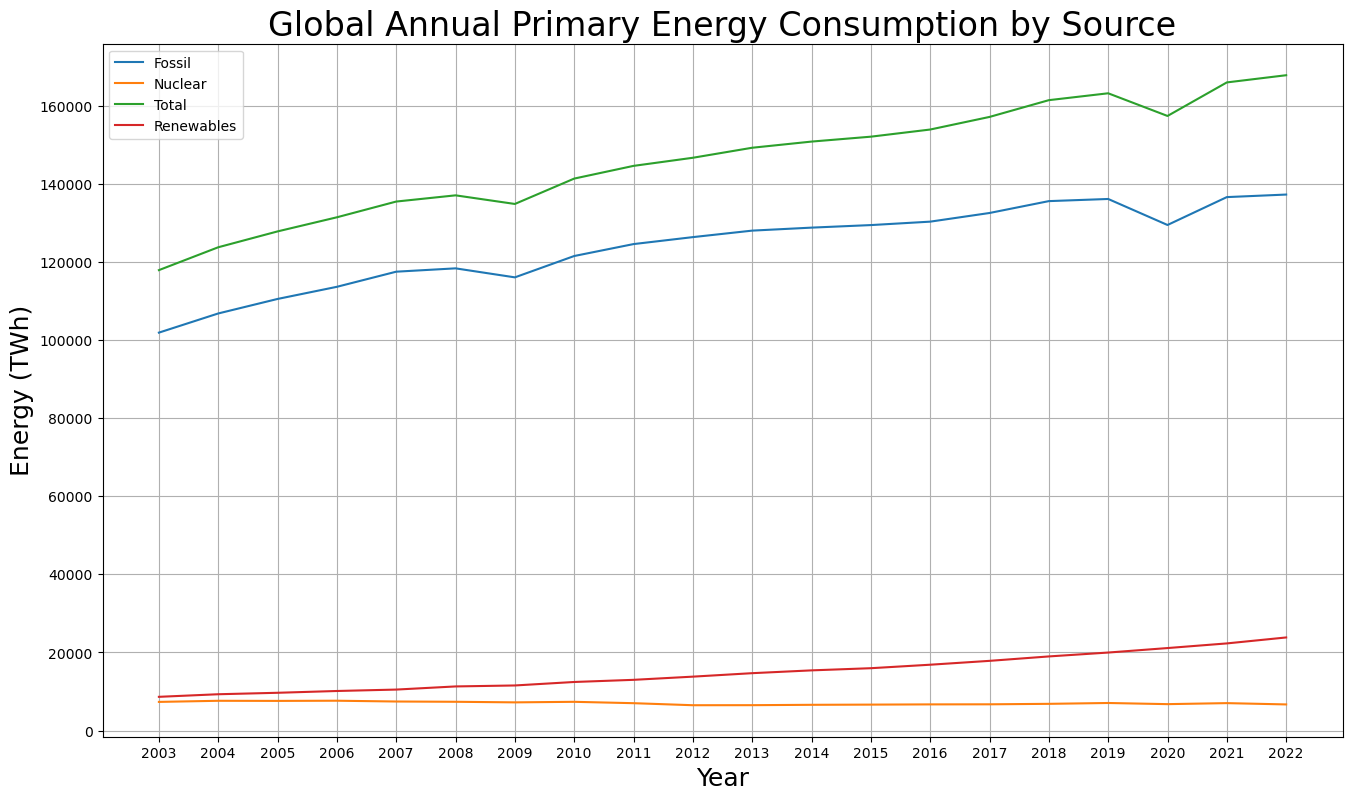

In [10]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Primary Energy Consumption by Source', size = 24)

plt.grid()

plt.savefig('images/global_annual_primary_energy_consumption_by_source.png')

plt.show()

## Actual Energy Consumption

### Global Actual Primary Energy Consumption by Region

In [11]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['primary_energy_consumption'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

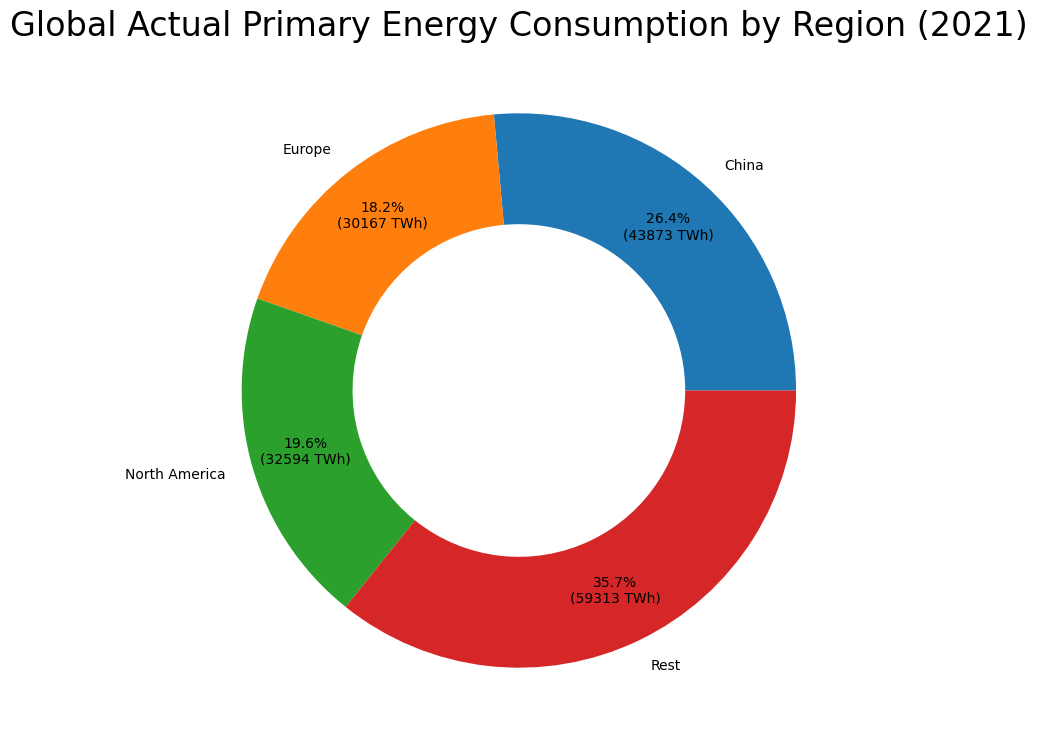

In [12]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

plt.title('Global Actual Primary Energy Consumption by Region (2021)', size = 24)

plt.savefig('images/global_actual_primary_energy_consumption_by_region.png')

plt.show()

### Global Actual Primary Energy Consumption by Source

In [13]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
    'primary_energy_consumption'   # total
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

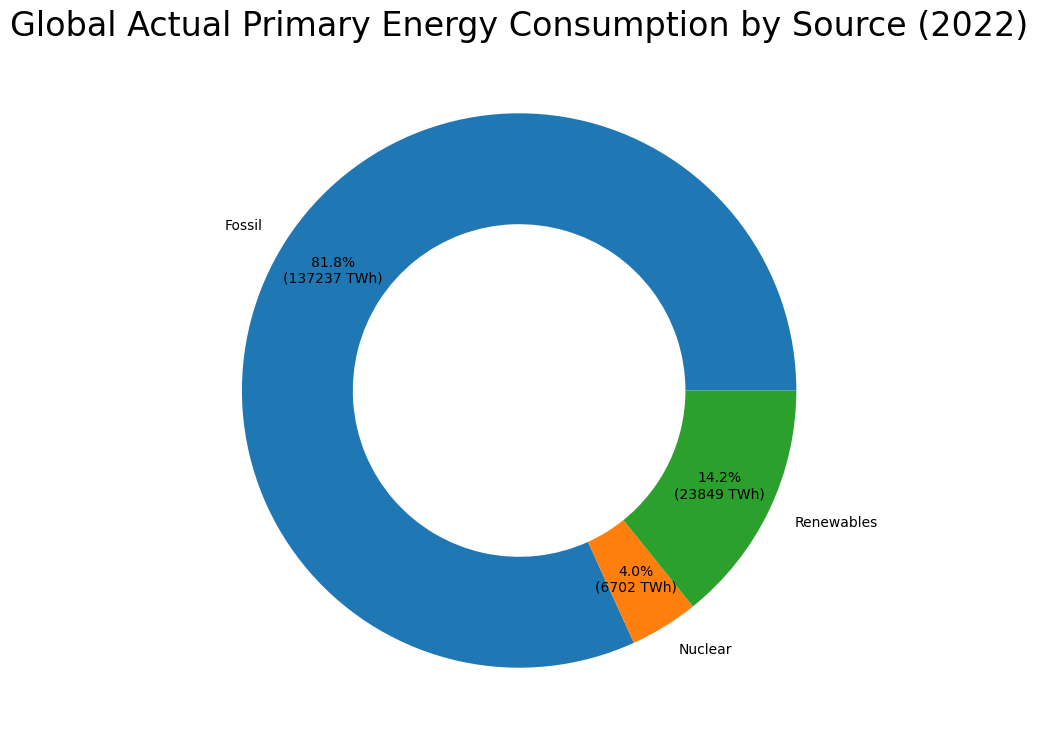

In [14]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

plt.title('Global Actual Primary Energy Consumption by Source (2022)', size = 24)

plt.savefig('images/global_actual_primary_energy_consumption_by_source.png')

plt.show()

# Electricity Generation

## Annual Electricity Generation

### Global Annual Electricity Generation by Region

In [15]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                        'China',
                        'Europe',
                        'North America',
]]

df = reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

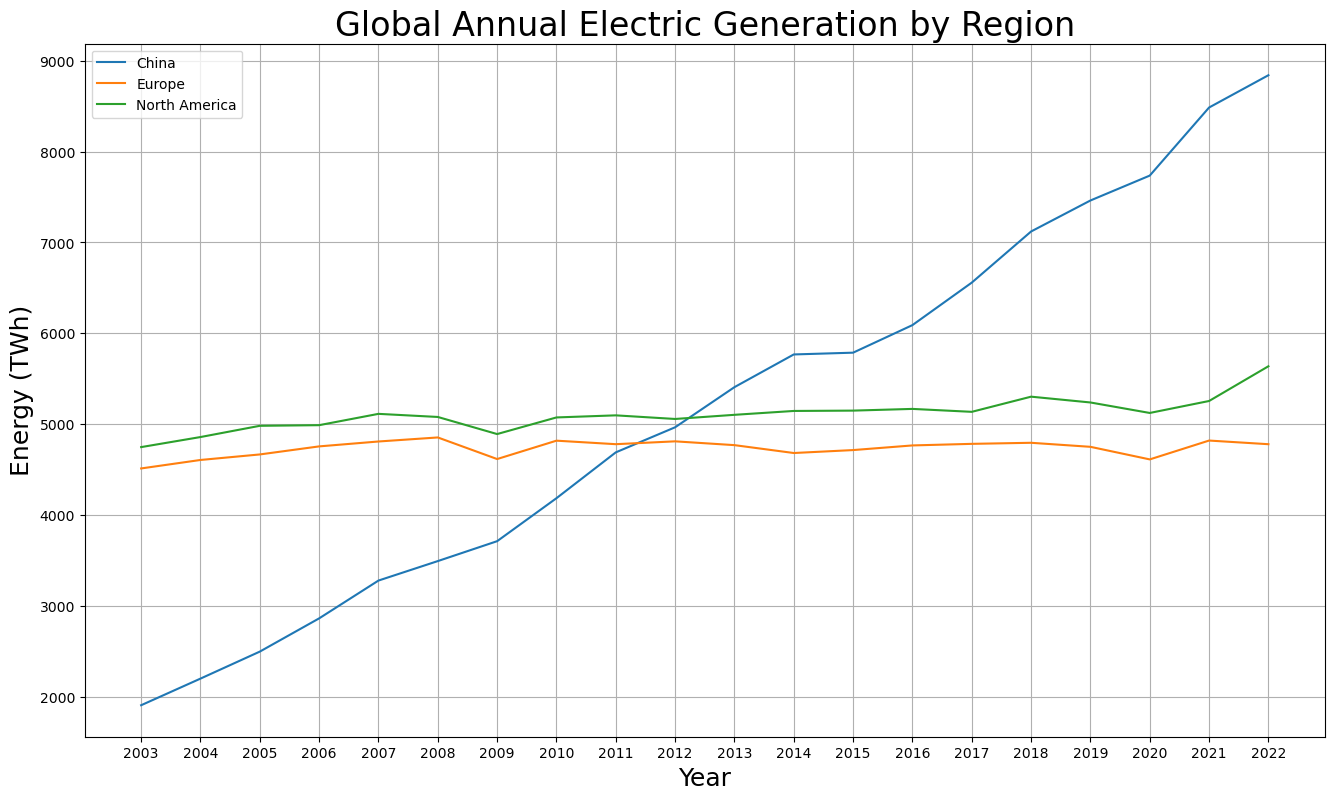

In [16]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Electric Generation by Region', size = 24)

plt.grid()

plt.savefig('images/global_annual_electricity_generation_by_region.png')

plt.show()

### Global Annual Electricity Generation by Source

In [17]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',      # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',            # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'electricity_demand',          # ... other ...
    'electricity_share_energy',  
    'other_renewable_exc_biofuel_electricity',
    'per_capita_electricity',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
    'electricity_generation': 'Total',
})

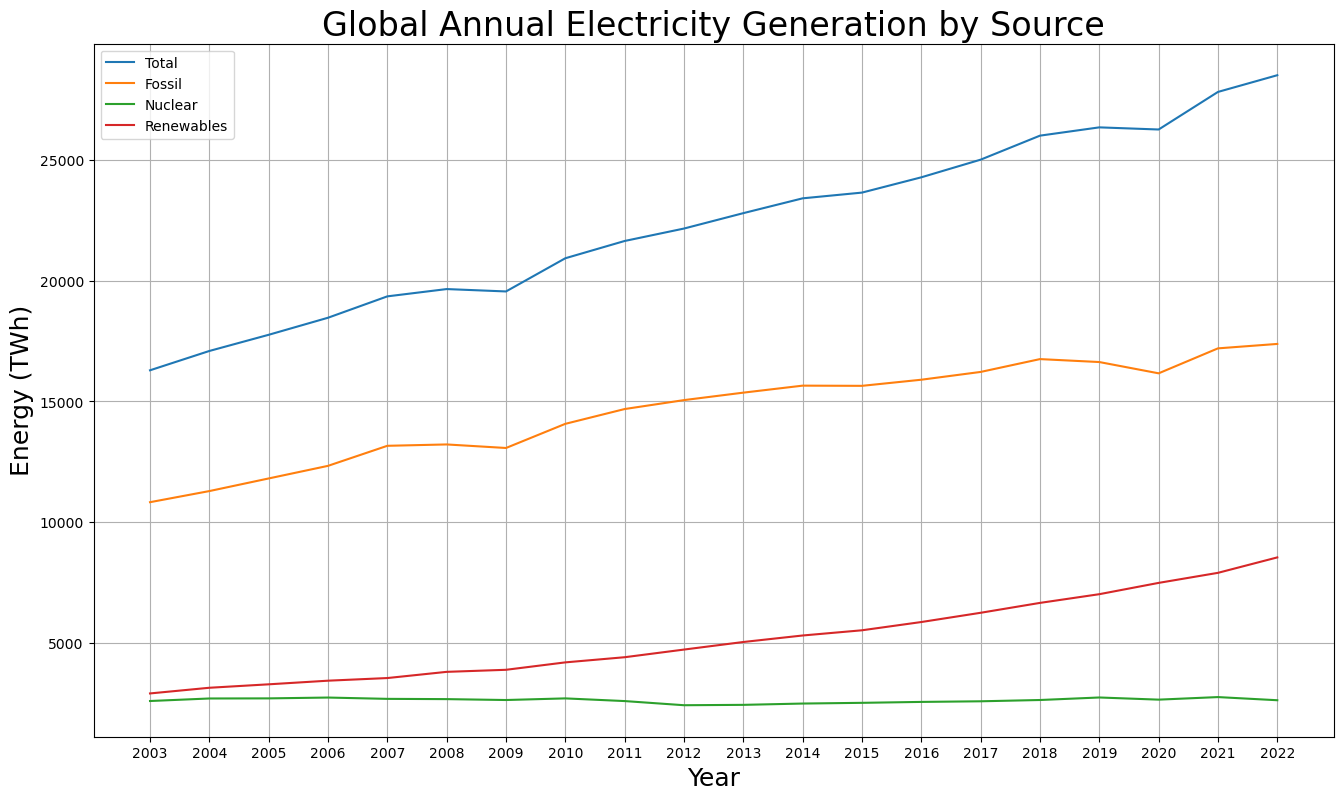

In [18]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year", size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Electricity Generation by Source', size = 24)

plt.grid()

plt.savefig('images/global_annual_electricity_generation_by_source.png')

plt.show()

## Actual Electricity Generation

### Actual Electricity Generation by Region

In [19]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['electricity_generation'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

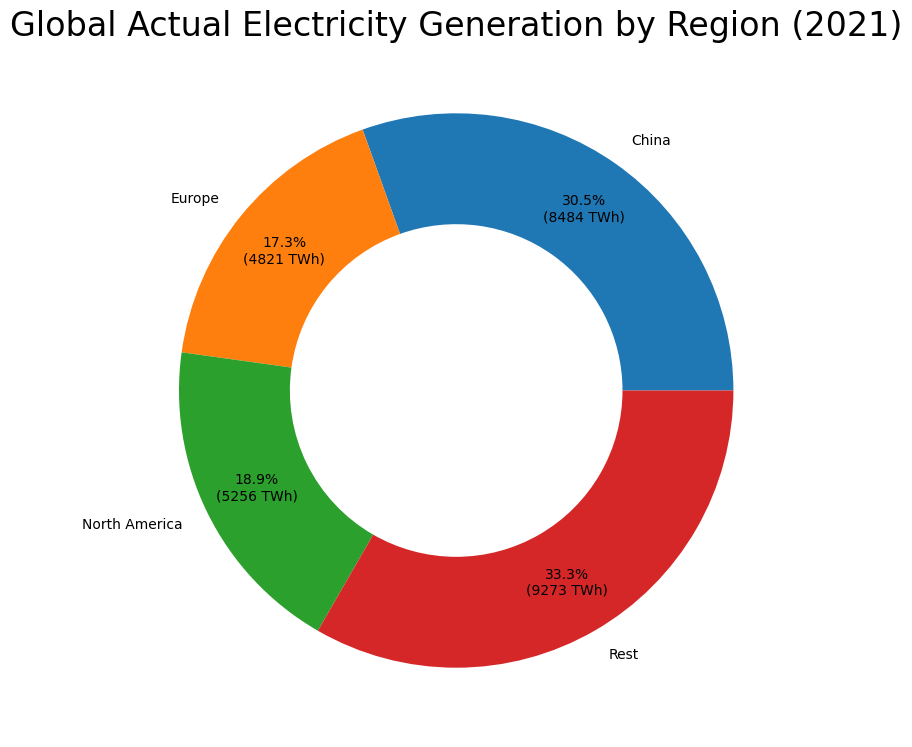

In [20]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

plt.title('Global Actual Electricity Generation by Region (2021)', size = 24)

# plt.savefig('images/global_actual_electricity_generation_by_region.png')

plt.show()

### Actual Electricity Generation by Source

In [21]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',                  # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity',
    'other_renewable_exc_biofuel_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',                        # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'per_capita_electricity',
    'electricity_demand',
    'electricity_generation',                   # total
    'electricity_share_energy',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

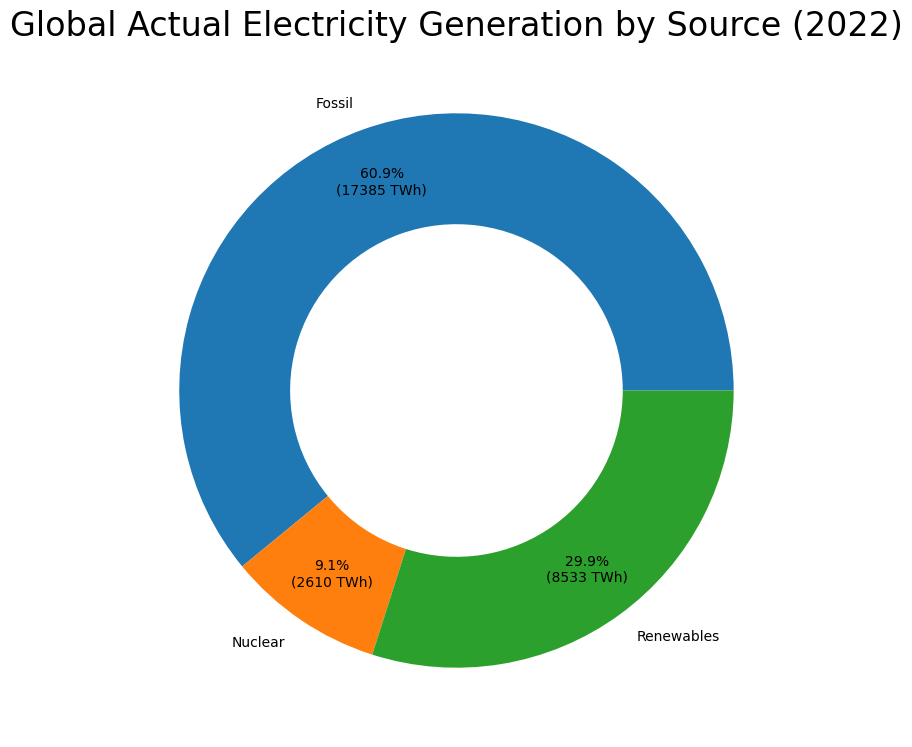

In [22]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

plt.title('Global Actual Electricity Generation by Source (2022)', size = 24)

plt.savefig('images/global_actual_electricity_generation_by_source.png')

plt.show()

![US energy consumption by source and sector, 2022](https://www.eia.gov/totalenergy/data/monthly/pdf/flow/css_2022.png)